In [3]:
import os
import torch
import numpy as np
from uncertainties import unumpy as unp
import h5py
from itertools import product
from deepqmc.ewm import EWMAverage
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font', family='serif', serif='STIXGeneral', size=10)

def to_corr(x, ref):
    return (ref[0] - x) / (ref[0] - ref[1])
def to_corr_error(x, ref):
    return x / (ref[0] - ref[1])

In [4]:
f = h5py.File(f'{os.path.dirname(os.getcwd())}/data/raw/data_pub_small_systems.h5', 'a')

In [5]:
def plot_mean_err(ax, data, ref_enes, bs, decay):
    step, E_loc = data
    E_mean = E_loc.mean(axis=1)
    ewm=EWMAverage(outlier_maxlen=3,outlier=3,decay_alpha=10)
    E_ewm = np.array([])
    for e in E_mean:
        ewm.update(e)
        E_ewm = np.append(E_ewm,ewm.mean)
    inds=np.geomspace(1,9_999,200).astype(int)    
    energy = to_corr(unp.nominal_values(E_ewm), ref_enes)
    err = to_corr_error(unp.std_devs(E_ewm), ref_enes)
    ax.plot(step[inds],1 - energy[inds])
    ax.fill_between(step[inds],1-(energy+err)[inds],1-(energy-err)[inds],color='grey',alpha=0.5)
    ax.set_xscale('log')
    ax.set_yscale('log')

/home/mi/zenoone/.cache/pypoetry/virtualenvs/dlqmc-at5iiCLG-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


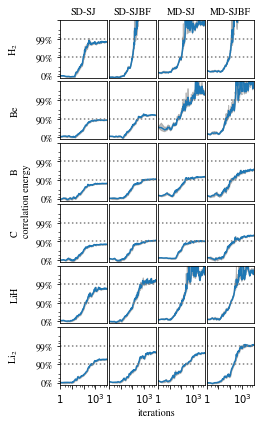

In [8]:
systems = ['H2','Be','B','C','LiH','Li2']
y_ticks = np.concatenate([np.linspace(10**(i-3),10**(i-2),5) for i in range(4)])
width = 3.47
fig, axes = plt.subplots(len(systems), 4, figsize=(width ,width*2), gridspec_kw={'hspace': 0.06, 'wspace': 0.04})
for (i, system), (j, ansatz) in product(
    enumerate(systems),
    enumerate(['SD-SJ', 'SD-SJBF', 'MD-SJ', 'MD-SJBF']),
):
    ax = axes[i, j]
    plot_mean_err(
        ax,
        (np.arange(0,10_000),f[system][ansatz]['train'][...]),
        f[system].attrs['ref_energy'],
        10_000,
        3,
    )
    if i == 0:
        ax.set_title(ansatz, fontdict={'fontsize': 10})
    if j == 0:
        ax.set_ylabel('$\mathregular{{ {0} }}$'.format(system.replace('2','_2')), labelpad=16)
    ax.set_xlim(1, 1e4)
    if i != len(systems)-1:
        ax.set_xticks([])
    else:
        ax.set_xticks([1, 10, 100, 1000])
        ax.set_xticklabels([r'$1$', '', '', r'$10^3$'])
        ax.set_xticks([2.5, 5, 7.5, 25, 50, 75, 250, 500, 750, 2500, 5000, 7500], minor=True)
    ax.set_xlabel(None)
    if j != 0:
        ax.set_yticks([])
        ax.set_ylabel(None)
    else:
        ax.set_yticks(y_ticks[y_ticks<1.3],minor=True)
        ax.set_yticks([1 ,1e-1, 1e-2, 1e-3])
        ax.set_yticklabels(['0%', '90%', '99%', ''])
    ax.set_ylim(1.3, 1e-3)
    for i in [0.1,0.01]:
        ax.axhline(i, color='grey', ls=':')     
fig.text(-0.01, 0.45, 'correlation energy', rotation='vertical', ha='center')
fig.text(0.51, 0.09, 'iterations', ha='center')
fig.tight_layout()
fig.subplots_adjust(bottom=0.15) 
#plt.savefig('learning-curves.pdf',bbox_inches='tight')